In [1]:
import hddm

passing through Knoderegress


/users/afengler/data/software/miniconda3/envs/hddm-gpu/lib/python3.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
import tensorflow as tf
import torch
# Make simulators visible
import sys
#sys.path.append('simulators')

# Data management
import pandas as pd
import numpy as np
import pickle

# Plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import pymc.progressbar as pbar
import pymc as pm


# Stats functionality
from statsmodels.distributions.empirical_distribution import ECDF

In [3]:
# Unused for now -------
def pretty_tag(tag):
    if len(tag) == 1:
        return tag[0]
    else:
        for tag_tmp in tag:
            tag_list.append(str(tag_tmp))
        return '(' + ', '.join(tag_list) + ')'
    
def data_processor(x):
    #print(x.shape)
    x = x[(x[:,0] < 999) & (x[:, 0] > -999), :]
    #print(np.min(x))
    #print(np.max(x))
    return x
# ----------------------

def _parents_to_random_posterior_sample(bottom_node, pos=None):
    """Walks through parents and sets them to pos sample."""
    for i, parent in enumerate(bottom_node.extended_parents):
        if not isinstance(parent, pm.Node): # Skip non-stochastic nodes
            continue

        if pos is None:
            # Set to random posterior position
            pos = np.random.randint(0, len(parent.trace()))

        assert len(parent.trace()) >= pos, "pos larger than posterior sample size"
        parent.value = parent.trace()[pos]
         
# Defining some functions to get posterior predictives fast !
def _get_sample(bottom_node = None, sim_model = 'ddm_legacy'):
    #print('passing through get sample')
    #ipdb.set_trace()
    theta_array = np.zeros((bottom_node.value.shape[0], len(ssms.config.model_config[sim_model]['params'])))
    cnt = 0
    for param in ssms.config.model_config[sim_model]['params']:
        theta_array[:, cnt] = bottom_node.parents.value[param]
        cnt += 1
    #print(np.sum(theta_array[0, :] < 0))
    out = ssms.basic_simulators.simulator(theta = theta_array, 
                                          model = sim_model, 
                                          n_samples = 1)
    out = pd.DataFrame(np.array([out['rts'], out['choices']]).squeeze().transpose(), columns = ['rt', 'choices'])
#     out = pd.DataFrame(out['rts'] * out['choices'], 
#                        columns = ['rt'])
    return out

def _post_pred_generate(bottom_node, sim_model = 'ddm_legacy', samples=500, data=None, append_data=False):
    """Generate posterior predictive data from a single observed node."""
    datasets = []

    ##############################
    # Sample and generate stats
    #for sample in tqdm(range(samples)):
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        sampled_data = _get_sample(bottom_node, sim_model = sim_model)
        
        # Generate data from bottom node
        #sampled_data = bottom_node.random()
        
        #return bottom_node.random()
        if append_data and data is not None:
            sampled_data = sampled_data.join(data.reset_index(), lsuffix='_sampled')
        datasets.append(sampled_data)

    return datasets

def post_pred_gen(model, groupby=None, samples=500, append_data=False, progress_bar=True, sim_model = 'ddm_legacy'):
    """Run posterior predictive check on a model.

    :Arguments:
        model : kabuki.Hierarchical
            Kabuki model over which to compute the ppc on.

    :Optional:
        samples : int
            How many samples to generate for each node.
        groupby : list
            Alternative grouping of the data. If not supplied, uses splitting
            of the model (as provided by depends_on).
        append_data : bool (default=False)
            Whether to append the observed data of each node to the replicatons.
        progress_bar : bool (default=True)
            Display progress bar

    :Returns:
        Hierarchical pandas.DataFrame with multiple sampled RT data sets.
        1st level: wfpt node
        2nd level: posterior predictive sample
        3rd level: original data index

    :See also:
        post_pred_stats
    """
    results = {}

    # Progress bar
    if progress_bar:
        n_iter = len(model.get_observeds())
        bar = pbar.progress_bar(n_iter)
        bar_iter = 0
    else:
        pass
        #print("Sampling...")

    if groupby is None:
        iter_data = ((name, model.data.iloc[obs['node'].value.index]) for name, obs in model.iter_observeds())
    else:
        iter_data = model.data.groupby(groupby)

    for name, data in iter_data:
        node = model.get_data_nodes(data.index)

        if progress_bar:
            bar_iter += 1
            bar.update(bar_iter)

        if node is None or not hasattr(node, 'random'):
            continue # Skip

        ##############################
        # Sample and generate stats
        datasets = _post_pred_generate(node, sim_model = sim_model, samples=samples, data=data, append_data=append_data)
        results[name] = pd.concat(datasets, names=['sample'], keys=list(range(len(datasets))))
        
        out = pd.concat(results, names=['node'])
        # print(out)
    return out

def _plot_posterior_pdf_node(bottom_node, axis, value_range=None, samples=2, bins=100, **kwargs):
    """Calculate posterior predictive for a certain bottom node.

    :Arguments:
        bottom_node : pymc.stochastic
            Bottom node to compute posterior over.

        axis : matplotlib.axis
            Axis to plot into.

        value_range : numpy.ndarray
            Range over which to evaluate the likelihood.

    :Optional:
        samples : int (default=10)
            Number of posterior samples to use.

        bins : int (default=100)
            Number of bins to compute histogram over.

    """
    #print('passing the main function')
    if value_range is None:
        # Infer from data by finding the min and max from the nodes
        raise NotImplementedError("value_range keyword argument must be supplied.")

    #like = np.empty((samples, len(value_range)), dtype=np.float32)
    datasets = []
    
    # Define bins
    master_bins = np.hstack((np.array(-999), np.arange(value_range[0], value_range[1], 0.1), np.array(999)))
    
    for sample in range(samples):
        _parents_to_random_posterior_sample(bottom_node)
        
        #sampled_data = bottom_node.random()
        sampled_data = _get_sample(bottom_node)
        datasets.append(sampled_data)
        
    for dataset in datasets:
        axis.hist(dataset['rt'].values, 
                  bins = master_bins,
                  density = True, 
                  histtype = 'step', 
                  color = 'black',
                  alpha = min(1, 3 / (samples)))
        
    # Plot data
    if len(bottom_node.value) != 0:
        data_processor = kwargs.pop('data_processor', None)
        
        if data_processor is None:
            processed_data = bottom_node.value.values
        else:
            processed_data = data_processor(bottom_node.value.values)
        
        counts, bins = np.histogram(np.squeeze(processed_data), 
                                    bins = master_bins, 
                                    density = True)

        axis.hist(master_bins[:-1], 
                  bins = master_bins, 
                  density = False, 
                  weights = counts,
                  color = 'blue',
                  label = 'data',
                  histtype = 'step',
                  lw = 1.)

    axis.set_xlim((value_range[0], value_range[1]))
    axis.set_ylim(bottom=0) # Likelihood and histogram can only be positive
    
def plot_posterior_predictive(model = None, sim_model = None, 
                              samples = None, bin_size = 0.05, 
                              save = False, save_file_name = None,
                              title = 'no_title'):
    
    cl_dct = {0: 'black',
              1: 'red',
              2: 'green',
              3: 'blue'}
                                      
    out = post_pred_gen(model, samples = samples, sim_model = sim_model)          
    for c in hddm.model_config.model_config[sim_model]['choices']:
        weights_pp = np.tile((1 / bin_size) / out['rt'].shape[0], reps = out['rt'][out['choices'] == c].shape[0])
        
        plt.hist(out['rt'][out['choices'] == c], 
                 density = False,
                 weights = weights_pp,
                 bins = np.arange(0, 10, bin_size),
                 histtype = 'step',
                 linestyle = '--',
                 color = cl_dct[c])
                     
        weights = np.tile((1 / bin_size) / model.data['rt'].shape[0], 
                          reps = model.data['rt'][model.data['response'] == c].shape[0]) 
        
        plt.hist(model.data['rt'][model.data['response'] == c], 
                 density = False,
                 weights = weights,
                 bins = np.arange(0, 10, bin_size),
                 histtype = 'step',
                 linestyle = '-',
                 color = cl_dct[c])
        
        plt.title(title)
    
    if save:
        plt.savefig(save_file_name + ".png", 
                    format = "png")
    plt.show()
    return 

In [64]:
# Metadata
nmcmc = 1000
#model = 'race_no_bias_4'
model = 'ddm_mic2_adj_angle_no_bias'
n_samples = 1500
includes = hddm.model_config.model_config[model]['hddm_include'].copy() # Note, this makes sure you include all parameters which is not necessary ! You could also instead include fewer parameters.

# # Drop some includes
# includes.remove('z')
# #includes.remove('g')
# #includes.remove('b')
# includes.remove('t')

In [95]:
# test regressors only False
# add p_outliers to the generator !
data, full_parameter_dict = hddm.simulators.hddm_dataset_generators.simulator_h_c(n_subjects = 1,
                                                                                  n_trials_per_subject = n_samples,
                                                                                  model = model,
                                                                                  p_outlier = 0.00,
                                                                                  conditions = None, 
                                                                                  depends_on = None, 
                                                                                  regression_models = None,
                                                                                  regression_covariates = None,
                                                                                  group_only_regressors = False,
                                                                                  group_only = None,
                                                                                  fixed_at_default = None)

None
{'theta', 'vh', 'vl2', 'd', 'a', 'vl1', 't'}
            vh       vl1       vl2         a         d         t     theta
0    -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475
1    -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475
2    -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475
3    -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475
4    -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475
...        ...       ...       ...       ...       ...       ...       ...
1495 -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475
1496 -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475
1497 -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475
1498 -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475
1499 -2.742201  2.199043  0.708568  0.298937  0.816217  0.927259  0.503475

[1500 rows x 7 columns]
z_vec shape
(1500,)
(1500

In [96]:
data

,rt,response,subj_idx,vh,vl1,vl2,a,d,t,theta
0,2.154887,0.0,0,0.755843,-2.344932,0.448147,1.441542,0.533752,0.497866,0.328127
1,1.147861,1.0,0,0.755843,-2.344932,0.448147,1.441542,0.533752,0.497866,0.328127
2,2.179889,0.0,0,0.755843,-2.344932,0.448147,1.441542,0.533752,0.497866,0.328127
3,1.640864,0.0,0,0.755843,-2.344932,0.448147,1.441542,0.533752,0.497866,0.328127
4,1.134861,1.0,0,0.755843,-2.344932,0.448147,1.441542,0.533752,0.497866,0.328127
...,...,...,...,...,...,...,...,...,...,...
1495,2.206890,1.0,0,0.755843,-2.344932,0.448147,1.441542,0.533752,0.497866,0.328127
1496,1.261860,0.0,0,0.755843,-2.344932,0.448147,1.441542,0.533752,0.497866,0.328127
1497,2.157888,0.0,0,0.755843,-2.344932,0.448147,1.441542,0.533752,0.497866,0.328127
1498,1.901876,3.0,0,0.755843,-2.344932,0.448147,1.441542,0.533752,0.497866,0.328127


In [97]:
hddmnn_torch_model.data

,rt,response,subj_idx,vh,vl1,vl2,a,d,t
0,2.573729,3.0,0,-0.52487,-1.18553,0.431133,0.763631,0.123422,0.785701
1,1.304698,3.0,0,-0.52487,-1.18553,0.431133,0.763631,0.123422,0.785701
2,1.330698,0.0,0,-0.52487,-1.18553,0.431133,0.763631,0.123422,0.785701
3,1.396697,3.0,0,-0.52487,-1.18553,0.431133,0.763631,0.123422,0.785701
4,3.095716,2.0,0,-0.52487,-1.18553,0.431133,0.763631,0.123422,0.785701
...,...,...,...,...,...,...,...,...,...
1495,2.389720,1.0,0,-0.52487,-1.18553,0.431133,0.763631,0.123422,0.785701
1496,1.327698,2.0,0,-0.52487,-1.18553,0.431133,0.763631,0.123422,0.785701
1497,1.959700,0.0,0,-0.52487,-1.18553,0.431133,0.763631,0.123422,0.785701
1498,1.691693,3.0,0,-0.52487,-1.18553,0.431133,0.763631,0.123422,0.785701


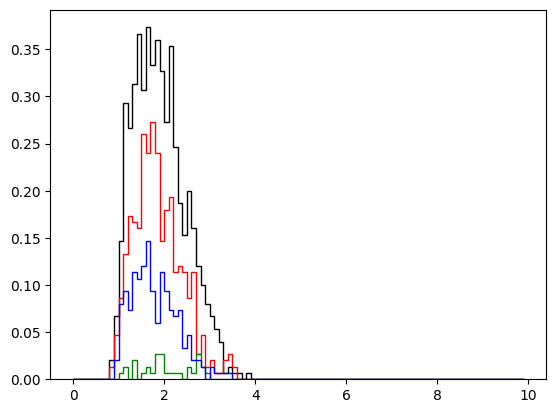

In [98]:
color = ['black', 'red', 'green', 'blue']
cnt = 0

for c in [0, 1, 2, 3]:
    choice_prop = data['rt'][data['response'] == c].shape[0] / data['rt'].shape[0]
    weights = np.tile(( 1 / 0.1 ) / n_samples , reps = data['rt'][data['response'] == c].shape[0])
    plt.hist(data['rt'][data['response'] == c], range = (0, 10), bins = np.arange(0, 10, 0.1), weights = weights, histtype = 'step', color = color[c])
    
plt.show()

In [99]:
# Define the HDDM model
hddmnn_torch_model = hddm.HDDMnn(data,
                                 informative = False,
                                 include = includes,
                                 p_outlier = 0.0,
                                 w_outlier = 0.01,
                                 model = model,
                                 network_type = 'torch_mlp')

# Define the HDDM model
# hddmnn_keras_model = hddm.HDDMnn(data,
#                            informative = False,
#                            include = includes,
#                            p_outlier = 0.0,
#                            w_outlier = 0.01,
#                            model = model,
#                            network_type = 'mlp')


# # Define the HDDM model
# hddm_model = hddm.HDDM(data,
#                            informative = False,
#                            include = ['z'],
#                            p_outlier = 0.0)

Setting priors uninformative (LANs only work with uninformative priors for now)
tanh
tanh
tanh
linear
def custom_likelihood(x, vh, vl1, vl2, a, d, t, theta, p_outlier=0.0, w_outlier=0.1, network = None):
    return hddm.wfpt.wiener_like_nn_mlp(x["rt"].values, x["response"].values, np.array([vh, vl1, vl2, a, d, t, theta], dtype = np.float32), p_outlier=p_outlier, w_outlier=w_outlier, network=network)
{'model': 'ddm_mic2_adj_angle_no_bias', 'likelihood_str': 'def custom_likelihood(x, vh, vl1, vl2, a, d, t, theta, p_outlier=0.0, w_outlier=0.1, network = None):\n    return hddm.wfpt.wiener_like_nn_mlp(x["rt"].values, x["response"].values, np.array([vh, vl1, vl2, a, d, t, theta], dtype = np.float32), p_outlier=p_outlier, w_outlier=w_outlier, network=network)', 'custom_likelihood': <function custom_likelihood at 0x7f9271772560>}
<function custom_likelihood at 0x7f9271772560>
{}
['vh', 'vl1', 'vl2', 'a', 'd', 't', 'theta']
printing self.nn
True
More than 2-choice model --> don't flip any resp

In [100]:
# Sample torch
hddmnn_torch_model.sample(1000,
                          burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 24.8 sec

In [31]:
# Sample torch
# hddmnn_keras_model.sample(nmcmc,
#                           burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 31.1 sec

In [32]:
# Sample torch
# hddm_model.sample(nmcmc,
#                   burn = 100)

 [-----------------100%-----------------] 1000 of 1000 complete in 14.0 sec

In [157]:
hddmnn_torch_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
vh,0.597291,0.027218,0.544796,0.578263,0.597228,0.615367,0.651245,0.000802
vl1,0.93858,0.068749,0.809782,0.891887,0.936761,0.984813,1.081744,0.002497
vl2,-2.444424,0.066886,-2.499053,-2.486408,-2.466694,-2.427442,-2.248619,0.003628
a,0.978652,0.012791,0.954846,0.970092,0.978594,0.986898,1.004121,0.000626
t,0.826339,0.0098,0.807,0.819805,0.826496,0.832864,0.845218,0.000507


In [158]:
data

,rt,response,subj_idx,vh,vl1,vl2,a,t
0,4.289828,3.0,0,0.607998,0.864896,-1.910642,0.965131,0.811898
1,2.504921,1.0,0,0.607998,0.864896,-1.910642,0.965131,0.811898
2,1.064898,2.0,0,0.607998,0.864896,-1.910642,0.965131,0.811898
3,2.069901,2.0,0,0.607998,0.864896,-1.910642,0.965131,0.811898
4,2.086902,1.0,0,0.607998,0.864896,-1.910642,0.965131,0.811898
...,...,...,...,...,...,...,...,...
1495,2.085901,1.0,0,0.607998,0.864896,-1.910642,0.965131,0.811898
1496,1.162897,2.0,0,0.607998,0.864896,-1.910642,0.965131,0.811898
1497,1.192897,2.0,0,0.607998,0.864896,-1.910642,0.965131,0.811898
1498,1.764889,2.0,0,0.607998,0.864896,-1.910642,0.965131,0.811898


In [149]:
hddm.simulators.simulator_single_subject(parameters = hddm.model_config.model_config[model]['default_params'],
                                         model = model)

Model:  ddm_seq2_no_bias
Parameters needed:  ['vh', 'vl1', 'vl2', 'a', 't']
[0.0, 0.0, 0.0, 1.0, 1.0]
theta is supplied as list --> simulator assumes n_trials = 1
z_vec shape
(1,)
(1,)
{'vh': array([0.], dtype=float32), 'vl1': array([0.], dtype=float32), 'vl2': array([0.], dtype=float32), 'a': array([1.], dtype=float32), 'zh': array([0.5], dtype=float32), 'zl1': array([0.5], dtype=float32), 'zl2': array([0.5], dtype=float32), 't': array([1.], dtype=float32), 's': 1.0, 'delta_t': 0.0010000000474974513, 'max_t': 20.0, 'n_samples': 1000, 'simulator': 'ddm_flexbound', 'boundary_fun_type': 'constant', 'possible_choices': [0, 1, 2, 3], 'trajectory': 'This simulator does not yet allow for trajectory simulation', 'boundary': array([1., 1., 1., ..., 1., 1., 1.], dtype=float32), 'model': 'ddm_seq2_no_bias'}
vh
0.0
vl1
0.0
vl2
0.0
a
1.0
t
1.0


(           rt  response subj_idx   vh  vl1  vl2    a    t
 0    3.622992         3     none  0.0  0.0  0.0  1.0  1.0
 1    1.379999         2     none  0.0  0.0  0.0  1.0  1.0
 2    2.445012         2     none  0.0  0.0  0.0  1.0  1.0
 3    4.889900         0     none  0.0  0.0  0.0  1.0  1.0
 4    4.157953         2     none  0.0  0.0  0.0  1.0  1.0
 ..        ...       ...      ...  ...  ...  ...  ...  ...
 995  3.549998         3     none  0.0  0.0  0.0  1.0  1.0
 996  2.356007         2     none  0.0  0.0  0.0  1.0  1.0
 997  1.872992         0     none  0.0  0.0  0.0  1.0  1.0
 998  3.845976         3     none  0.0  0.0  0.0  1.0  1.0
 999  2.681023         0     none  0.0  0.0  0.0  1.0  1.0
 
 [1000 rows x 8 columns],
 {'vh': 0.0, 'vl1': 0.0, 'vl2': 0.0, 'a': 1.0, 't': 1.0})

In [ ]:
color = ['black', 'red', 'green', 'blue']
cnt = 0

for c in [0, 1, 2, 3]:
    choice_prop = data['rt'][data['response'] == c].shape[0] / data['rt'].shape[0]
    weights = np.tile(( 1 / 0.1 ) / n_samples , reps = data['rt'][data['response'] == c].shape[0])
    plt.hist(data['rt'][data['response'] == c], range = (0, 10), bins = np.arange(0, 10, 0.1), weights = weights, histtype = 'step', color = color[c])
    
plt.show()

 [-----------------100%-----------------] 1 of 1 complete in 0.0 secProportion go, real data
1.0
Positive rt prop, simulator
1.0


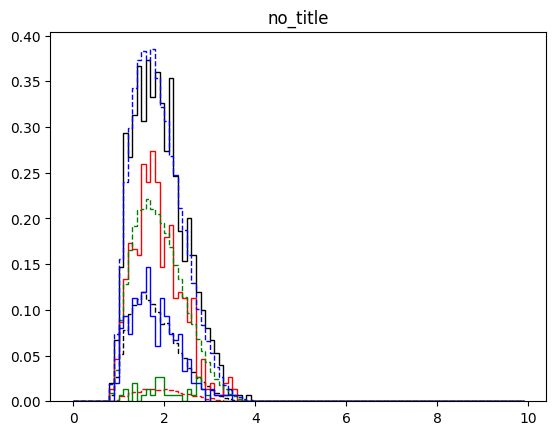

In [101]:
import ssms
plot_posterior_predictive(model = hddmnn_torch_model,
                          sim_model = model,
                          samples = 100,
                          bin_size = 0.1)
                                                    
# def plot_posterior_predictive(model = None, sim_model = None, 
#                               samples = None, bin_size = 0.05, 
#                               save = False, save_file_name = None,
#                               title = 'no_title'):

In [38]:
hddmnn_torch_model.get_traces()[['v0', 'v1']].values

array([[1.54455746, 1.61732388],
       [1.58817084, 1.61753159],
       [1.55117404, 1.72396647],
       ...,
       [0.31210396, 0.35524397],
       [0.14225538, 0.31175138],
       [0.36948323, 0.46735897]])

In [37]:
# Make theta

stats = hddmnn_torch_model.gen_stats()['mean'].transpose()
stats_names = list(hddmnn_torch_model.gen_stats()['mean'].transpose().keys())


theta = []
for param in hddm.model_config.model_config[model]['params']:
    if param in stats_names:
        theta.append(stats[param])
    else:
        theta.append(hddm.model_config.model_config[model]['default_params'][hddm.model_config.model_config[model]['params'].index(param)])
        
theta = np.array(theta)

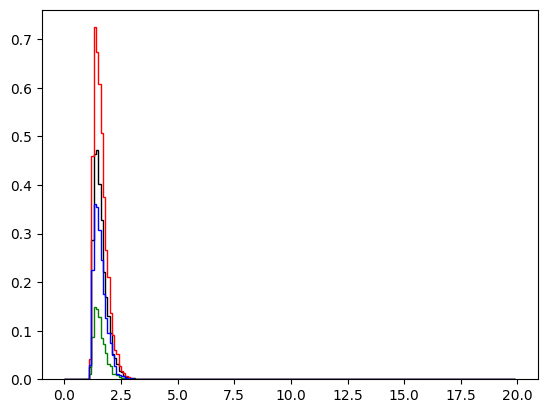

In [38]:
# Check if posteriors make sense
import ssms
#model = 'ddm_seq2_no_bias'
#d_s = [0, 0.25, 0.5, 1]

n_samples = 20000
hddmnn_torch_model.gen_stats()['mean']
theta = hddmnn_torch_model.gen_stats()['mean'].values.astype(np.float32)
out = ssms.basic_simulators.simulator(theta = theta,
                                      model = model,
                                      n_samples = n_samples)

#if d == 0:
color = ['black', 'red', 'green', 'blue']
cnt = 0

for c in [0, 1, 2, 3]:
    choice_prop = out['rts'][out['choices'] == c].shape[0] / out['rts'].shape[0]
    weights = np.tile(( 1 / 0.1 ) / n_samples , reps = out['rts'][out['choices'] == c].shape[0])
    plt.hist(out['rts'][out['choices'] == c], range = (0, 20), bins = np.arange(0, 20, 0.1), weights = weights, histtype = 'step', color = color[c])
    
plt.show()
#else:
#plt.hist(out['rts'][out['choices'] == 3], range = (0, 1), bins = 100, histtype = 'step', alpha = d, color = 'black')

In [93]:
np.array(data.iloc[0][[param for param in hddm.model_config.model_config[model]['params']]])

array([-1.431507917673074, 0.5997881302419039, 0.9607139246296809,
       1.4819353405980555, 0.13097992230935881, 0.4802770658979401],
      dtype=object)

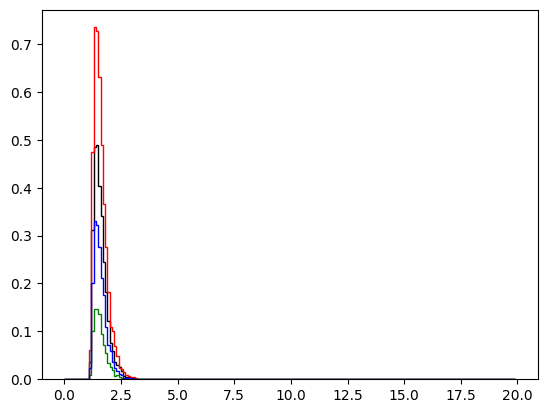

In [39]:
# Check if posteriors make sense
import ssms
#model = 'ddm_seq2_no_bias'
#d_s = [0, 0.25, 0.5, 1]

n_samples = 20000
theta_gt = np.array(data.iloc[0][[param for param in hddm.model_config.model_config[model]['params']]])
out = ssms.basic_simulators.simulator(theta = theta_gt,
                                      model = model,
                                      n_samples = n_samples)

#if d == 0:
color = ['black', 'red', 'green', 'blue']
cnt = 0

for c in [0, 1, 2, 3]:
    choice_prop = out['rts'][out['choices'] == c].shape[0] / out['rts'].shape[0]
    weights = np.tile(( 1 / 0.1 ) / n_samples , reps = out['rts'][out['choices'] == c].shape[0])
    plt.hist(out['rts'][out['choices'] == c], range = (0, 20), bins = np.arange(0, 20, 0.1), weights = weights, histtype = 'step', color = color[c])
    
plt.show()
#else:
#plt.hist(out['rts'][out['choices'] == 3], range = (0, 1), bins = 100, histtype = 'step', alpha = d, color = 'black')

In [40]:
my_model = hddm.network_inspectors.load_torch_mlp(model = model)
n_choices = 4
choice_options = [0, 1, 2, 3]

rts = np.expand_dims(np.concatenate([np.arange(0, 20, 0.01) for i in range(n_choices)]), axis = 1) #, np.arange(0,10, 0.01), np.arange(0,10, 0.01)]), axis = 1)
choices = np.concatenate([[c for i in range(2000)] for c in choice_options])
thetas = np.tile(np.array(theta_gt), reps = (rts.shape[0],1))
my_data = np.column_stack([thetas, rts, choices]).astype(np.float32)

my_data = np.column_stack([my_data, np.exp(my_model.predict_on_batch(my_data))])

tanh
tanh
tanh
linear


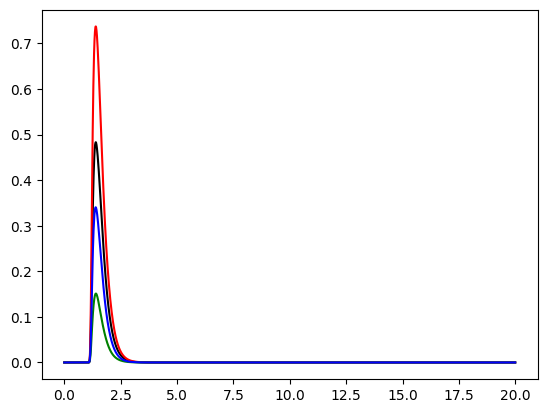

In [41]:
color = ['black', 'red', 'green', 'blue']

for c in [0, 1, 2, 3]: #  2, 3]:
    plt.plot(my_data[my_data[:, -2] == c, -3], my_data[my_data[:, -2] == c, -1], color = color[c])
    
plt.show()

In [97]:
my_model = hddm.network_inspectors.load_torch_mlp(model = model)
n_choices = 4
choice_options = [0, 1, 2, 3]

rts = np.expand_dims(np.concatenate([np.arange(0, 20, 0.01) for i in range(n_choices)]), axis = 1) #, np.arange(0,10, 0.01), np.arange(0,10, 0.01)]), axis = 1)
choices = np.concatenate([[c for i in range(2000)] for c in choice_options])
thetas = np.tile(np.array(theta), reps = (rts.shape[0],1))
my_data = np.column_stack([thetas, rts, choices]).astype(np.float32)

my_data = np.column_stack([my_data, np.exp(my_model.predict_on_batch(my_data))])

tanh
tanh
tanh
linear


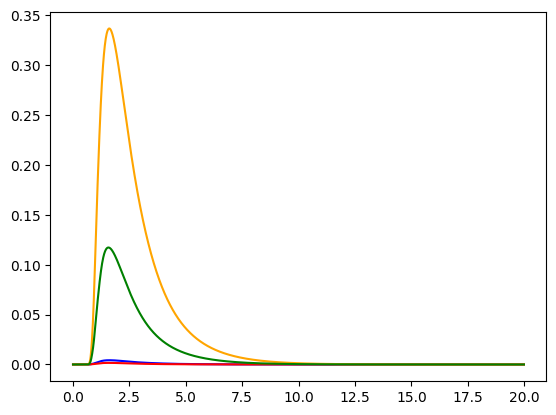

In [98]:
color = ['blue', 'red', 'orange', 'green']

for c in [0, 1, 2, 3]: #  2, 3]:
    plt.plot(my_data[my_data[:, -2] == c, -3], my_data[my_data[:, -2] == c, -1], color = color[c])
    
plt.show()

In [90]:
hddmnn_torch_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,-0.835013,0.063645,-0.972336,-0.870727,-0.828122,-0.789445,-0.725923,0.005049
a,1.953415,0.127402,1.703743,1.861096,1.962274,2.049738,2.184857,0.011269
z,0.218581,0.02364,0.2,0.200035,0.204935,0.23738,0.276275,0.002294
t,1.461071,0.017235,1.423085,1.45041,1.462389,1.473978,1.490604,0.001452
alpha,2.14477,0.373354,1.583839,1.866542,2.091147,2.374833,3.023263,0.021018
beta,5.901999,0.652729,4.636328,5.399552,5.928585,6.470178,6.946675,0.039786


In [34]:
hddmnn_keras_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
v,1.539898,0.084923,1.374631,1.487195,1.534603,1.597418,1.713643,0.00631
a,1.114885,0.058523,0.998365,1.072007,1.118218,1.156703,1.227973,0.004703
z,0.286156,0.021858,0.243743,0.271483,0.285931,0.301284,0.328868,0.001338
alpha,1.162843,0.116063,1.002862,1.039103,1.169018,1.261626,1.35958,0.00836
t,1.504488,0.007513,1.489581,1.499506,1.504313,1.509378,1.519018,0.000381


In [35]:
hddm_model.gen_stats()

,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,2.049559,0.035724,1.984713,2.025258,2.047264,2.073232,2.122854,0.001638
v,0.975918,0.046257,0.88843,0.943815,0.976287,1.007558,1.063487,0.002427
t,1.392762,0.008219,1.375611,1.387262,1.393266,1.398697,1.407272,0.000369
z,0.369303,0.010904,0.348281,0.362223,0.369599,0.376583,0.390254,0.000526


In [81]:
dir(hddmnn_torch_model.mcmc().db)

['__Trace__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_finalize',
 '_initialize',
 '_traces',
 'chains',
 'close',
 'commit',
 'connect_model',
 'dbname',
 'getstate',
 'savestate',
 'tally',
 'trace',
 'trace_names',
 'truncate']

In [82]:
hddmnn_torch_model.mcmc().db.trace_names

[]

In [86]:
hddm_model.mcmc().db.trace_names

[]

In [87]:
hddm_model.get_traces()

,a,v,t,z_trans
0,3.981690,0.707008,1.552127,-0.229724
1,3.966550,0.687102,1.558296,-0.278494
2,4.010323,0.695428,1.504113,-0.281882
3,4.044400,0.698848,1.530022,-0.293732
4,4.025534,0.719221,1.515409,-0.331316
...,...,...,...,...
895,4.175195,0.752149,1.422557,-0.417910
896,4.151741,0.766553,1.441120,-0.360975
897,4.210276,0.764354,1.441521,-0.348054
898,4.120845,0.746528,1.509580,-0.282352


In [100]:
hddm_model.mc.db._traces

{}

In [101]:
hddm_model.get_stochastics()

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,rt,response,...,z,t,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,a,True,False,False,a,(),[],False,NaN,NaN,...,NaN,NaN,4.122176,0.086789,3.959831,4.066472,4.116039,4.178776,4.303092,0.005541
v,v,True,False,False,v,(),[],False,NaN,NaN,...,NaN,NaN,0.726471,0.028049,0.670944,0.70685,0.726347,0.745147,0.78047,0.001583
t,t,True,False,False,t,(),[],False,NaN,NaN,...,NaN,NaN,1.469925,0.041688,1.380997,1.44598,1.473405,1.498159,1.543966,0.0028
z_trans,z_trans,True,False,False,z_trans,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
hddm_model.get_deterministic()

AttributeError: 'HDDM' object has no attribute 'get_deterministic'

In [107]:
hddm_model.nodes_db

,knode_name,stochastic,observed,subj,node,tag,depends,hidden,rt,response,...,z,t,mean,std,2.5q,25q,50q,75q,97.5q,mc err
a,a,True,False,False,a,(),[],False,NaN,NaN,...,NaN,NaN,4.122176,0.086789,3.959831,4.066472,4.116039,4.178776,4.303092,0.005541
v,v,True,False,False,v,(),[],False,NaN,NaN,...,NaN,NaN,0.726471,0.028049,0.670944,0.70685,0.726347,0.745147,0.78047,0.001583
t,t,True,False,False,t,(),[],False,NaN,NaN,...,NaN,NaN,1.469925,0.041688,1.380997,1.44598,1.473405,1.498159,1.543966,0.0028
z_trans,z_trans,True,False,False,z_trans,(),[],True,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
z,z,False,False,False,z,(),[],False,NaN,NaN,...,NaN,NaN,0.419083,0.013539,0.392202,0.409575,0.419275,0.428044,0.44562,0.00079
wfpt,wfpt,False,True,False,wfpt,(),[],False,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
tmp = hddm_model.nodes_db[(hddm_model.nodes_db.stochastic == True) | ((hddm_model.nodes_db.stochastic == False) & (hddm_model.nodes_db.observed == False))] # hddm_model.nodes_db.observed == False]
#tmp = tmp[tmp.observed == False, ]

In [150]:
for idx in tmp.index:
    print(idx)
    print(tmp.loc[idx].node.trace())
    #print(tmp[idx, :].node)

a
[3.98169021 3.96655014 4.0103234  4.0443996  4.02553372 4.20615519
 4.20799522 4.27602711 4.05944572 4.09083529 4.15850348 4.24022004
 4.37821522 4.31625564 4.30358808 4.39928537 4.24026939 4.32644424
 4.26290777 4.36117385 4.15317485 4.09653808 4.01510439 3.95706678
 4.07426519 4.08115854 4.16978896 4.22319548 4.16246874 4.10635118
 4.03978538 4.19035219 4.12815013 4.13959789 4.1130292  4.06727276
 4.10156489 4.1148719  4.07776562 4.10012619 4.17934604 4.03319202
 4.01171902 4.1716917  4.20872426 4.12819977 4.1285183  4.01436927
 3.97476322 4.12231352 4.12040578 4.13519032 4.13730257 4.03080863
 4.08951122 4.11937272 4.20955866 4.18793679 4.11087322 4.09627027
 4.06754745 4.05960332 4.18505823 4.15629928 4.21165445 4.18999043
 4.15210362 4.08771046 4.07282351 4.05822566 4.12235091 4.17523446
 4.18189757 4.18416237 4.17877646 4.04208591 4.21242929 4.11587211
 4.1439344  4.17295062 4.09427375 4.11016041 4.09618955 4.13573604
 4.1071792  4.08403836 4.09064926 4.20510071 4.03064387 4.07

In [145]:
tmp.index

Index(['a', 'v', 't', 'z_trans', 'z'], dtype='object')

In [127]:
tmp.loc['z', :].node.trace()

array([0.44282035, 0.43082297, 0.42999242, 0.42709049, 0.41792048,
       0.42256716, 0.4182892 , 0.41898075, 0.42047371, 0.40500877,
       0.4134671 , 0.40693889, 0.37949011, 0.37895345, 0.39552337,
       0.38754605, 0.40964192, 0.42360087, 0.42798751, 0.42355866,
       0.42541122, 0.42266353, 0.43738353, 0.43508919, 0.41811747,
       0.40963267, 0.41614237, 0.39836867, 0.40427717, 0.41181476,
       0.41257876, 0.4104638 , 0.43476855, 0.44558916, 0.4323991 ,
       0.43798861, 0.43375284, 0.42377155, 0.410446  , 0.42008577,
       0.41899661, 0.41517313, 0.42323658, 0.43893135, 0.44054828,
       0.44561996, 0.44157254, 0.42685977, 0.4086088 , 0.41733168,
       0.41712416, 0.43069211, 0.40948367, 0.40851257, 0.42465862,
       0.42361234, 0.41231257, 0.40596166, 0.40960605, 0.41263802,
       0.40539327, 0.42323285, 0.42977926, 0.43955877, 0.43142307,
       0.43059441, 0.42431218, 0.422591  , 0.42812361, 0.42668915,
       0.42067417, 0.41130513, 0.43863816, 0.42860179, 0.42155